# Assignment 2:  the perceptron

Due date:  Friday 9/21 at 11:59pm

Name: Rohan Jhaveri



## Datasets

In this assignment we will use the following datasets:
  * The [Gisette](http://archive.ics.uci.edu/ml/datasets/Gisette) handwritten digit recognition dataset. 
  * The [QSAR](http://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation) data for predicting the biochemical activity of a molecule.
  * The [Heart disease diagnosis](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) dataset.
  * For developing your code, you can use one of the scikit-learn datasets, such as the [breast cancer wisconsin dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) and the [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) toy dataset generator.
  
When writing your notebook, you can assume the datasets are in the same directory as the notebook.  Please keep the same file names as in the UCI repository.
  

## Part 1:  Variants of the perceptron algorithm 

In this assignment you will work with several variants of the perceptron algorithm:

  * The "vanila" version of the perceptron algorithm, which was introduced in class.
  * The pocket algorithm as described in the slides or page 80 in the book.
  * The **adatron** version of the perceptron described next.

In each case make sure that your implementation of the classifier **includes a bias term** (in slide set 2 and page 7 in the book you will find guidance on how to add a bias term to an algorithm that is expressed without one).

## The adatron 

Before we get to the adatron, we will derive an alternative form of the perceptron algorithm --- the dual perceptron algorithm.  All we need to look at is the weight update rule:

$$\mathbf{w} \rightarrow \mathbf{w} + \eta y_i \mathbf{x}_i.$$

This is performed whenever example $i$ is misclassified by the current weight vector.  The thing to notice, is that the weight vector is always a weighted combination of the training examples since it is that way to begin with, and each update maintains that property.  So in fact, rather than representing $\mathbf{w}$ explicitly, all we need to do is to keep track of how much each training example is contributing to the value of the weight vector, i.e. we will express it as:

$$\mathbf{w} = \sum_{i=1}^N \alpha_i y_i \mathbf{x}_i,$$

where $\alpha_i$ are positive numbers that describe the magnitude of the contribution $\mathbf{x}_i$ is making to the weight vector, and $N$ is the number of training examples.

Therefore to initialize $\mathbf{w}$ to 0, we simply initialize $\alpha_i = 0$ for $i = 1,\ldots,N$.  When expressed using the variables $\alpha_i$, the perceptron update rule becomes:

$$\alpha_i = \alpha_i + \eta y_i,$$

and you can always retrieve the weight vector using its expansion in terms of the $\alpha_i$.

Now we're ready for the adatron - the only difference is in the initialization and update equation.

Initialization:

$\alpha_i = 1$ for $i = 1,\ldots,N$

Like in the perceptron we run the algorithm until convergence, or until a fixed number of epochs has passed (an epoch is a loop over all the training data), and an epoch of training consists of the following procedure:

for each training example $i=1,\ldots,N$ perform the following steps:

1.  $\gamma = y_i * \mathbf{w}^{t} \mathbf{x}_i$
2.  $\delta\alpha = \eta * (1 - \gamma)$
3.  `if` $(\alpha_i + \delta\alpha < 0)$ : $\alpha_i = 0$, `else : ` $\alpha_i = \alpha_i + \delta\alpha$


The variable $\eta$ plays the role of the learning rate $\eta$ employed in the perceptron algorithm and $\delta \alpha$ is the proposed magnitude of change in $\alpha_i$. 
We note that the adatron tries to maintain a **sparse** representation in terms of the training examples by keeping many $\alpha_i$ equal to zero.  The adatron converges to a special case of the SVM algorithm that we will learn later in the semester; this algorithm tries to maximize the margin with which each example is classified, which is captured by the variable $\gamma$ in the algorithm (notice that the magnitude of change proposed for each $\alpha_i$ becomes smaller as $\gamma$ increases towards 1).

**Note:** if you observe an overflow issues in running the adatron, add an upper bound on the value of $\alpha_i$.

Here's what you need to do:

  - Implement the pocket algorithm and the adatron; each classifier should be implemented in a separate Python class, and use the same interface used in the code provided for the perceptron algorithm, i.e. provides the same methods with the same signature.  Make sure each classifier you use (including the original version of the perceptron) implements a bias term.
  - Compare the performance of these variants of the perceptron on the Gisette and QSAR datasets by computing an estimate of the out of sample error on a sample of the data that you reserve for testing (the test set).  In each case reserve about 60% of the data for training, and 40% for testing.  To gain more confidence in our error estimates, repeat this experiment using 10 random splits of the data into training/test sets.  Report the average error and its standard deviation in a nicely formatted table.  Is there a version of the perceptron that appears to perform better?   (In answering this, consider the differences in performance you observe in comparison to the standard deviation).



**Importing packages**

In [81]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
import random as rand
from io import StringIO
import csv
import pandas as pd
from sklearn.model_selection import train_test_split #This packet splits the data set into training and testing 
                                                     #dataset with stratified partionong keeping the ratio of both 
                                                     #the dataset constant 
from sklearn import preprocessing

**QSAR Dataset**

In [72]:
def QSARDataExtract():
    dataArray = pd.read_csv("biodeg.csv", delimiter=";", header=None)
    Data_Y = dataArray.iloc[0:1055, 41]                    #labels
    Data_X = dataArray.iloc[0:1055, 0:41]                  #features
    # make col 41 values numerical
    Data_Y = np.where(Data_Y == "RB", 1, -1)
    return Data_X, Data_Y

**Gissette Dataset**

In [73]:
def GisetteDataExtract():
    train_X=np.genfromtxt("gisette_train.data", delimiter=" ", comments="#")
    train_Y=np.genfromtxt("gisette_train.labels", delimiter=" ", comments="#")
    valid_X=np.genfromtxt("gisette_valid.data", delimiter=" ", comments="#")
    valid_Y=np.genfromtxt("gisette_valid.labels", delimiter=" ", comments="#") 
    
    train_data_label = np.append(train_X, train_Y[:,None], axis=1)
    valid_data_label = np.append(valid_X, valid_Y[:,None], axis=1)
    
    dataFrame = np.concatenate((train_data_label, valid_data_label), axis=0)
    return dataFrame

def gisette_data_split(dataFrame, shuffle = True):
    #dataFrame = GisetteDataExtract()
    data_Y = dataFrame[:, 5000]                        #labels
    data_X = dataFrame[0:7000, 0:5000]                 #features
    train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.4, shuffle = shuffle, stratify = data_Y)
    return train_X, train_Y, test_X, test_Y, data_X, data_Y

**Perceptron Class**

In [84]:
class Perceptron :
 
    def __init__(self, max_iterations=1000, learning_rate=0.2) :
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate

# Data training without biased   
    def train_unbias(self, X, y) :
        self.w = np.zeros(len(X[0]))
        converged = False
        iterations = 0
        while (not converged and iterations < self.max_iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * self.decision_function(X[i]) <= 0 :
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False
            iterations += 1
        self.converged = converged

# Data training with biased             
    def train_bias(self, X, y) :
        X = np.hstack((np.ones((len(X),1)),X))       #Adding bias term
        self.w = np.zeros(len(X[0]))                #Initialize weight to zero 
        converged = False
        iterations = 0
        count = 0
        while (not converged and iterations < self.max_iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * (self.decision_function(X[i])) <= 0 :
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False      
            iterations += 1
        self.converged = converged
      
    
#   Data testing for unbiased           
    def test_unbias(self,X,y):
        count = 0
        print (self.w)
        for i in range (len(X)):
            if np.sign(self.decision_function(X[i])) == y[i]:
                count += 1
        accuracy = float(count) / len(X)
        Eout = 1 - accuracy     
        return(Eout)

# Data testing for bias
    def test_bias(self,X,y):
        X = np.hstack((np.ones((len(X),1)),X))
        count = 0
        print (self.w)
        for i in range (len(X)):
            if np.sign(self.decision_function(X[i])) == y[i]:
                count += 1
        accuracy = float(count) / len(X)
        Eout = 1 - accuracy         
        return(Eout)
              
    def decision_function(self, X) :
        return np.inner(self.w, X)
             
    def predict(self, X) :     
        scores = np.inner(self.w, X)
        return np.sign(scores)

**Pocket Class**

In [75]:
class Pocket :
 
    def __init__(self, max_iterations=1000, learning_rate=0.2) :
 
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate

#Data training 
    def train_pocket(self, X, y) :
        X = np.hstack((np.ones((len(X),1)),X))                      #Adding bias term
        self.w = np.zeros(len(X[0]))                                #Initialize weight to zero
        self.pocketW = self.w                                       #Copy the current weight to pocket weigth 
        converged = False
        iterations = 0
        while (not converged and iterations < self.max_iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * (self.decision_function(X[i])) <= 0 :
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False
                    if (self.error_in(self.pocketW, X, y) > self.error_in(self.w, X, y)): #update weight if the current weight gives better result that the pocket weight 
                        self.pocketW = self.w
            iterations += 1
        self.converged = converged
        
        print ('pocket W: ')
        print (self.pocketW)
        print ('Weight')
        print (self.w)
       

 # Data testing
    def test_pocket(self,X,y):
        X = np.hstack((np.ones((len(X),1)),X))
        Eout = (np.sum(np.sign(np.inner(self.pocketW, X)) != y))/len(y)         
        print ("Eout: %f" %Eout)
        return(Eout)

 #In sample error calculation
    def error_in(self,w,X,y):
        scores = np.inner(w,X)
        error = (np.sum(np.sign(scores)!=y))/len(y)
        return error
 
    def decision_function(self, x) :
        return np.inner(self.w, x)
             
    def predict(self, X) :     
        bias = np.ones((np.size(X, 0), 1)) 
        X = np.append(bias, X, 1)         
        scores = np.inner(self.pocketW, X) 
        return np.sign(scores) 

**Adatron Class**

In [76]:
class Adatron :
    
    def __init__(self, max_iterations=1000, learning_rate=0.2) :
 
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate

# Data training
    def  train_adatron(self, X, y):
        bias = np.ones((np.size(X, 0), 1))       # Adding bias
        X = np.append(bias, X, 1)   
        self.alpha = np.ones((np.size(X, 0))) # initializing a Nx1 vector of alphas
        
        iterations = 0
        m = np.zeros((len(X[0]), len(X))) 
        for i in range(len(X)):
            m[: , i] = self.alpha[i]*y[i]*X[i]   
        self.w = m@np.ones((np.size(X, 0), 1)) 
        self.w = self.w.reshape(len(X[0]),) 
        
        while (iterations <= self.max_iterations):         
            for i in range(len(X)):            
                gamma = y[i] * self.decision_function(X[i])        # calculate gamma
                delta_alpha = self.learning_rate * (1-gamma)     #  calculate deviation in alpha
                self.w = self.w - (self.alpha[i] * y[i] * X[i])               
                if (self.alpha[i] + delta_alpha < 0):            # update alpha
                    self.alpha[i] = 0
                else:
                    self.alpha[i] = self.alpha[i] + delta_alpha                
                if (self.alpha[i] > 5000): 
                    self.alpha[i] = 5000       
                self.w = self.w + (self.alpha[i] * y[i] * X[i])            
            iterations += 1
        

# Data testing
    def test_adatron(self,X,y):
        X = np.hstack((np.ones((len(X),1)),X))
        count = 0
        print (self.w)
        for i in range (len(X)):
            if np.sign(self.decision_function(X[i])) == y[i]:
                count += 1
        accuracy = float(count) / len(X)
        Eout = 1 - accuracy         
        print ("Eout: %f" %Eout)
        return(Eout)
         
     
    def decision_function(self, x) :
        return np.inner(self.w, x)
             
    def predict(self, X) :    
        bias = np.ones((np.size(X, 0), 1)) 
        X = np.append(bias, X, 1)        
        scores = np.inner(self.w, X) 
        return np.sign(scores) 

In [77]:
# main function

if __name__=='__main__' :
    p = Perceptron()
    po = Pocket()
    a = Adatron()
    #-------Gisette----------
    Biased_Eout = []
    Biased_Eout_Pocket = []
    Biased_Eout_Adadtron = []
    #-------QSAR----------
    Biased_Eout_QSAR = []
    Biased_Eout_QSAR_Pocket =[]
    Biased_Eout_QSAR_Adadtron = []
    
   
    print("----------Perceptron Gisette------------")
    
    dataFrame = GisetteDataExtract()
    error = 0
    Biased_mean = 0
    Biased_sd = 0
    for i in range(10):
        train_X, train_Y, test_X, test_Y, X, Y = gisette_data_split(dataFrame)
        p.train_bias(train_X,train_Y)
        error = p.test_bias(test_X,test_Y)
        Biased_Eout.append(error)
    Biased_mean = np.mean(Biased_Eout)    
    Biased_sd = np.std(Biased_Eout)
    print("---------Perceptron Biased(Gissette)----------")
    print("List of Eout is:\n",Biased_Eout)
    print("Mean of all Eout is:", Biased_mean)
    print("Standard Deviation of all Eout is:", Biased_sd)

    
    print("----------Perceptron QSAR------------")
    
    Data_X, Data_Y = QSARDataExtract()
    error = 0 
    Biased_mean_QSAR=0
    Biased_sd_QSAR=0
    for i in range(10):
        train_X,  test_X, train_Y, test_Y = train_test_split(Data_X, Data_Y, test_size=0.4, stratify = Data_Y)
        p.train_bias(train_X,train_Y)
        error = p.test_bias(test_X,test_Y)
        Biased_Eout_QSAR.append(error)
    Biased_mean_QSAR = np.mean(Biased_Eout_QSAR)    
    Biased_sd_QSAR = np.std(Biased_Eout_QSAR)
    print("---------Perceptron Biased(QSAR)----------")
    print("List of Eout is:\n",Biased_Eout_QSAR)
    print("Mean of all Eout is:", Biased_mean_QSAR)
    print("Standard Deviation of all Eout is:", Biased_sd_QSAR)
    
    
    print("----------Pocket Gisette------------")
    
    dataFrame = GisetteDataExtract()
    error = 0
    Pocket_mean=0
    Pocket_sd=0
    for i in range(10):
        train_X, train_Y, test_X, test_Y, X, Y = gisette_data_split(dataFrame)
        po.train_pocket(train_X,train_Y)
        error = po.test_pocket(test_X,test_Y)
        Biased_Eout_Pocket.append(error)
    Pocket_mean = np.mean(Biased_Eout_Pocket)    
    Pocket_sd = np.std(Biased_Eout_Pocket)
    print("---------Pocket----------")
    print("List of Eout is:\n",Biased_Eout_Pocket)
    print("Mean of all Eout is:", Pocket_mean)
    print("Standard Deviation of all Eout is:", Pocket_sd)
    

    print("----------Pocket QSAR------------")
    
    Data_X, Data_Y = QSARDataExtract()
    error = 0
    Biased_mean_QSAR = 0
    Biased_sd_QSAR = 0
    for i in range(10):
        train_X,  test_X, train_Y, test_Y = train_test_split(Data_X, Data_Y, test_size=0.4, stratify = Data_Y)
        po.train_pocket(train_X,train_Y)
        error = po.test_pocket(test_X,test_Y)
        Biased_Eout_QSAR_Pocket.append(error)
    Biased_mean_QSAR = np.mean(Biased_Eout_QSAR_Pocket)    
    Biased_sd_QSAR = np.std(Biased_Eout_QSAR_Pocket)
    print("---------Pocket Biased(QSAR)----------")
    print("List of Eout is:\n",Biased_Eout_QSAR_Pocket)
    print("Mean of all Eout is:", Biased_mean_QSAR)
    print("Standard Deviation of all Eout is:", Biased_sd_QSAR)
    
    
     
    print("----------Adatron Gisette------------")
    
    dataFrame = GisetteDataExtract()
    error = 0
    Adatron_mean = 0
    Adatron_sd = 0
    for i in range(10):
        train_X, train_Y, test_X, test_Y, X, Y = gisette_data_split(dataFrame)
        a.train_adatron(train_X,train_Y)
        error = a.test_adatron(test_X,test_Y)
        Biased_Eout_Adadtron.append(error)
    Adatron_mean = np.mean(Biased_Eout_Adadtron)    
    Adatron_sd = np.std(Biased_Eout_Adadtron)
    print("---------Adatron----------")
    print("List of Eout is:\n",Biased_Eout_Adadtron)
    print("Mean of all Eout is:", Adatron_mean)
    print("Standard Deviation of all Eout is:", Adatron_sd)
    
    
    print("----------Adatron QSAR------------")
    
    Data_X, Data_Y = QSARDataExtract()
    error = 0
    Adatron_mean = 0
    Adatron_sd = 0 
    for i in range(10):
        train_X,  test_X, train_Y, test_Y = train_test_split(Data_X, Data_Y, test_size=0.4, stratify = Data_Y)
        a.train_adatron(train_X,train_Y)
        error = a.test_adatron(test_X,test_Y)
        Biased_Eout_Adadtron.append(error)
    Adatron_mean = np.mean(Biased_Eout_Adadtron)    
    Adatron_sd = np.std(Biased_Eout_Adadtron)
    print("---------Adatron Biased(QSAR)----------")
    print("List of Eout is:\n",Biased_Eout_Adadtron)
    print("Mean of all Eout is:", Adatron_mean)
    print("Standard Deviation of all Eout is:", Adatron_sd)
    
    

----------Perceptron Gisette------------
[ 5.55111512e-17 -2.83800000e+02 -3.56000000e+01 ...  1.37200000e+02
 -1.49100000e+03  9.74200000e+02]
[-5.55111512e-17 -5.69000000e+02 -2.89800000e+02 ... -3.41000000e+02
 -8.17200000e+02  4.23800000e+02]
[   0.8 -230.2  320.2 ... -728.2  258.4   46.4]
[-2.0000e-01 -1.1954e+03  6.0360e+02 ... -3.9380e+02 -1.0456e+03
 -9.2260e+02]
[-4.0000e-01  5.7620e+02  4.9000e+01 ... -2.5200e+01 -1.5864e+03
  1.0790e+03]
[ 2.0000e-01  1.0896e+03  2.8200e+02 ... -5.2420e+02 -2.7080e+02
  5.6780e+02]
[ 2.0000e-01  5.4360e+02  8.9540e+02 ... -1.0904e+03  1.6296e+03
  8.2340e+02]
[-5.55111512e-17 -6.12200000e+02  3.43600000e+02 ... -1.34500000e+03
 -6.33200000e+02  7.05800000e+02]
[-4.000e-01  1.580e+01 -3.104e+02 ...  3.320e+01 -9.230e+02 -8.508e+02]
[ 2.000e-01  2.354e+02 -4.420e+02 ... -1.068e+02  5.480e+02 -9.594e+02]
---------Perceptron Biased(Gissette)----------
List of Eout is:
 [0.04107142857142854, 0.0346428571428572, 0.03214285714285714, 0.035714285714

pocket W: 
[-4.0000e-01 -9.2660e+02  8.7340e+02 ... -9.5840e+02 -1.4048e+03
  7.7940e+02]
Weight
[-4.0000e-01 -9.2660e+02  8.7340e+02 ... -9.5840e+02 -1.4048e+03
  7.7940e+02]
Eout: 0.031786
---------Pocket----------
List of Eout is:
 [0.035, 0.03, 0.03464285714285714, 0.035, 0.03, 0.03, 0.03464285714285714, 0.028214285714285713, 0.03357142857142857, 0.031785714285714285]
Mean of all Eout is: 0.03228571428571429
Standard Deviation of all Eout is: 0.002449489742783179
----------Pocket QSAR------------
pocket W: 
[-7.000000e+00 -3.467900e+01 -8.850402e+01 -6.080000e+01 -2.460000e+01
 -2.320000e+01 -2.040000e+02 -1.230000e+02  1.062000e+01  1.780000e+01
 -3.400000e+01  4.600000e+00  5.971000e+00 -1.650046e+02  1.066968e+02
  4.714940e+01  1.800000e+00  2.588000e-01 -1.372120e+01 -1.960000e+01
 -2.544000e+02 -2.200000e+00  6.242200e+00  2.000000e-01  1.430000e+02
 -7.800000e+01  4.700000e+01 -3.604400e+01 -6.939340e+01  5.040000e+01
  1.085240e+01 -1.382600e+00 -1.706000e+02  4.600000e+01 

pocket W: 
[  11.6      -28.7568  -111.60288  -37.6      -20.       -54.4
 -198.8     -102.        22.98       9.2       58.4        3.
   -1.011   -105.1198    30.3962     4.782     -8.        14.2672
   12.5438   -13.8      -58.4       -1.8       24.3152  -123.4
  -14.4      -15.4       31.2       15.7426   -18.0088   -57.
    5.9982     3.3682  -162.2       -0.6      -42.8       59.
   21.3016    63.0496   -37.8      -42.2006   132.2      -62.8    ]
Weight
[ -31.6      -2.3184 -146.6905  -33.2     -61.2     -65.2    -325.
 -145.4      26.2       9.8      32.4      -1.8      -6.7194 -317.5514
   52.6316   56.6698   10.2      -9.5428  -45.0822  -55.     -153.8
   -1.8      34.9034 -126.4      13.6     -74.8     107.6      65.2594
  -83.4852 -183.        4.5074   16.7288 -220.2       6.6     -42.2
   91.       96.8758   85.6408  -66.2     -91.4416  126.6     -46.2   ]
Eout: 0.144550
---------Pocket Biased(QSAR)----------
List of Eout is:
 [0.13744075829383887, 0.13981042654028436, 0.15

#### Description:
From the above results we can say that, the perceptron algorithm updates the weight for each feature. Whereas in Pocket algoirithm, the weight for which the error is minimum, is considered. In Adatron, the weight is dependent on the contributionn parameter ($\alpha$ - a).


|Variants|Mean Error| Standard Deviation|
|--|--|--|
|Gisette-Perceptron|0.03557|0.003199|
|QSAR-Perceptron|0.1699|0.04383|
|Gisette-Pocket|0.032285|0.002449|
|QSAR-Pocket|0.14194|0.01291|
|Gisette-Adatron|0.08582|0.03494|
|QSAR-Adatron|0.2164|0.15548|

From the above results, we can conclude that the error for Gisette data set is minimum with Pocket Algorithm and maximum error is seen with Adatron Algorithm. For QSAR data set the error is minimum with Pocket Algorithm and maximum error is seen with Adatron Algorithm.

This could be because the pocket algorithm considers the best possible weight for the given sample.

## Part 2:  Learning Curves 

Whenever we train a classifier it is useful to know if we have collected a sufficient amount of data for accurate classification.  A good way of determining that is to construct a **learning curve**, which is a plot of classifier performance (i.e. its error) as a function of the number of training examples.  Plot a learning curve for the perceptron algorithm (with bias) using the Gisette dataset.  The x-axis for the plot (number of training examples) should be on a logarithmic scale - something like 10,20,40,80,200,400,800.  Use numbers that are appropriate for the dataset at hand, choosing values that illustrate the variation that you observe.  What can you conclude from the learning curve you have constructed?  Make sure that you use a fixed test set to evaluate performance while varying the size of the training set.

0.17142857142857143
0.16428571428571428
0.13968253968253969
0.13214285714285715
0.12857142857142856
0.11746031746031746
0.11360544217687076
0.10535714285714286
0.10264550264550265
0.10047619047619048
0.09956709956709957
0.09484126984126984
0.09194139194139195
0.09047619047619047
0.08984126984126985
0.0880952380952381
0.08739495798319327
0.08544973544973546
0.0837092731829574


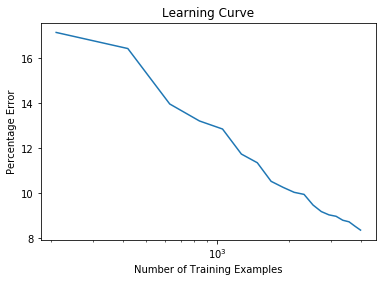

[-1.000e-01  6.208e+02 -8.060e+01 ... -3.190e+02 -2.208e+02  5.405e+02]
Accuracy: 0.968929
Eout: 0.031071
([17.142857142857142, 16.428571428571427, 13.968253968253968, 13.214285714285715, 12.857142857142856, 11.746031746031745, 11.360544217687076, 10.535714285714286, 10.264550264550266, 10.047619047619047, 9.956709956709958, 9.484126984126984, 9.194139194139195, 9.047619047619047, 8.984126984126984, 8.80952380952381, 8.739495798319327, 8.544973544973546, 8.37092731829574], [210.0, 420.0, 630.0, 840.0, 1050.0, 1260.0, 1470.0, 1680.0, 1890.0, 2100.0, 2310.0, 2520.0, 2730.0, 2940.0, 3150.0, 3360.0, 3570.0, 3780.0, 3990.0])


In [89]:
import numpy as np
from numpy import linalg as la
import random as rand
from matplotlib import pyplot as plt
 
class Perceptron_learning_curve :
 
    def __init__(self, max_iterations=100, learning_rate=0.1) :
 
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
 
    def train_bias(self, X, y) :
        
        X = np.hstack((np.ones((len(X),1)),X))
        self.w = np.zeros(len(X[0]))
        converged = False
        iterations = 0
        count = 0
        Error = []
        range_j = []        
        j = len(X)/20      
        while (not converged and iterations < self.max_iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * (self.decision_function(X[i])) <= 0 :
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False       
                    if np.sign(self.decision_function(X[i])) == y[i]:
                        count += 1
                if i == j : 
                    err = (float(count) / j )
                    accuracy = (1- err)*100
                    print(err)
                    Error.append(err*100)
                    
                    range_j.append(j)                    
                    j += len(X)/20
            iterations += 1
        self.converged = converged
        plot_data(Error,range_j)
        return(Error, range_j)            
                                 
    def test_bias(self,X,y):
        X = np.hstack((np.ones((len(X),1)),X))
        count = 0
        print (self.w)
        for i in range (len(X)):
            if np.sign(self.decision_function(X[i])) == y[i]:
                count += 1
        accuracy = float(count) / len(X)
        Eout = 1 - accuracy     
        print ("Accuracy: %f" %accuracy)    
        print ("Eout: %f" %Eout)
        return()
         
     
    def decision_function(self, x) :
        return np.inner(self.w, x)
             
    def predict(self, X) :
         
        scores = np.inner(self.w, X)
        return np.sign(scores)
         
def plot_data(Error, range_j) :
    plt.xscale('log')
    plt.plot(range_j, Error)   
    plt.xlabel("Number of Training Examples")
    plt.ylabel("Percentage Error")          
    plt.title("Learning Curve")
    plt.show() 
 
if __name__=='__main__' :
    accuracy = []
    p = Perceptron_learning_curve()
    dataFrame = GisetteDataExtract()
    train_X, train_Y, test_X, test_Y, X, Y = gisette_data_split(dataFrame)
    accuracy = p.train_bias(train_X,train_Y)
    p.test_bias(test_X,test_Y)
    print (accuracy)
    
   

**Results  of  the  learning  curve**:
The  learning  curve  obtained  from  Gisette  data  is  an  ever  decreasing  curve.
It  starts  at  approximately 22%  accuracy  and  goes  up  to  about  8%.  This shows  that  the  accuracy  of  the algorithm  increases  with  the  number  of training  examples.  When  there  are  more  training  examples,  the algorithm has  more  data  to  work  with  and  the  weights  get  updated  more  accurately  which  leads  to  a better  result. 

## Part 3:  Data normalization 

In this section we will explore the effect of normalizing the data, focusing on normalization of features.  The simplest form of normalization is to scale each feature to be in the range [-1, 1].  We'll call this **scaling**.

Here's what you need to do:

  - Explain how to scale the data to be in the range [-1, 1].
  - Compare the accuracy of the perceptron with bias on the original data and the scaled version of the heart dataset.  Does one of them lead to better performance?  Explain why you think this happens.  
  - An alternative way of normalizing the data is to **standardize** it:  for each feature subtract the mean and divide by its standard deviation.  What can you say about the range of the resulting features in this case?  




**Solution**
#### 1. Scaling  the  data  to  be  in  the  range  [-1,  1].

Data  can  be  normalized  such  that  scaled  data  will  be  range  of  [-1,1]  bymultiplying  the  selected  value  with  the  absolute  maximum  term  in  thesame  feature.  
$$Normalized({X})  = \frac{X}{abs(Max)}$$

**Heart data extraction** 

In [85]:
def train_scaled_data():                                #data extraction with scaling
    data=np.genfromtxt("heart.data", delimiter=",", comments="#")
    min_max_scaler = preprocessing.MinMaxScaler()    
    data = data[:,1:]
    train_y = data[:170,:1]
    train_X = min_max_scaler.fit_transform(data[:170,1:])
    return train_X,train_y

def test_scaled_data():                              #data testing for scaled dataset
    data=np.genfromtxt("heart.data", delimiter=",", comments="#")
    min_max_scaler = preprocessing.MinMaxScaler()    
    data = data[:,1:]
    test_y = data[170:,:1]
    test_X = min_max_scaler.fit_transform(data[170:,1:])
    return test_X,test_y

def train_data():                                    #data extraction without scaling
    data=np.genfromtxt("heart.data", delimiter=",", comments="#") 
    data = data[:,1:]
    train_y = data[:170,:1]
    train_X = data[:170,1:]
    return train_X,train_y

def test_data():                                     #data testing for non-scaled datatset 
    data=np.genfromtxt("heart.data", delimiter=",", comments="#")
    data = data[:,1:]
    test_y = data[170:,:1]
    test_X = data[170:,1:]
    return test_X,test_y

In [87]:
if __name__=='__main__' :
    
    p = Perceptron()
    error1 = 0
    error2 = 0
    train_X, train_Y = train_data()
    test_X, test_Y = test_data()        
    p.train_bias(train_X,train_Y)
    error1 = p.test_bias(test_X,test_Y)
    print("Error without scaling", error1)
    
    scaled_train_X, scaled_train_Y = train_scaled_data()
    scaled_test_X, scaled_test_Y = test_scaled_data()        
    p.train_bias(scaled_train_X,scaled_train_Y)
    error2 = p.test_bias(scaled_test_X,scaled_test_Y)
    print("Error with scaling", error2)

[ 1.4000e+00 -2.4740e+02  8.7780e+02  1.8162e+03  2.1980e+02  9.0000e+00
  1.6920e+02  1.6572e+03 -1.8280e+02  6.9360e+02  1.7902e+03  1.1232e+03
  3.3854e+03  2.6078e+03]
Error without scaling 0.52
[-1.20000000e+00 -1.00000000e+00  4.00000000e-01  4.66666667e-01
  1.35094340e+00  8.23744292e-01 -5.55111512e-17  1.00000000e-01
 -9.14516129e-01  2.00000000e-01  8.21428571e-02  7.00000000e-01
  2.40000000e+00  6.50000000e-01]
Error with scaling 0.25


#### 2. Error for Scaled and Without Scaled Data:
Scaling the data puts all the features within the set limits. This takes less number of iterations to converge to the best solutions. Hence, scaling gives us less error compared to without scaling.

|Variant|Accuracy %|Error|
|-|--|--|
|Original Data|48|0.52|
|Scaled Data|75|0.25|


#### 3.  Scaling  VS  Standardization.

The  main  difference  between  the  2  methods  of  normalization  is  that  we  can  have a  set  boundaries  for scaled  data  where  as  the  standardized  data  is unbounded. Both  the  approaches  have  their  advantages  and  limits. Scaling can  discard  some  information  which  can  be  a  problem  sometimes  and standardization  isn’t  very  useful  when  the  minimum  and  maximum  values of  a  data  are  unclear. Standardized  can  be  a  better  idea  when  the  range  of  features  is  large  and distance  plays  a  role  in  generating  weights.  For  instance  in  Support  Vector Machine,  a  feature  with  greater  numerical  value  can  over  shadow  a  feature with  smaller  numerical  value.